In [1]:
# !pip uninstall tensorflow
# !pip uninstall tensorflow-gpu
# !pip uninstall tf-nightly

# !pip install  tensorflow
# !pip install tensorflow-gpu
# !pip install  tf-nightly

In [2]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
# !unzip -q kagglecatsanddogs_3367a.zip
# !ls PetImages

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import losses
from tensorflow.keras import backend as K

In [4]:
import matplotlib.pyplot as plt

In [5]:
import six
from tensorflow.python.framework import smart_cond
from tensorflow.python.util.tf_export import keras_export
from tensorflow.python.keras.utils import losses_utils
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops.losses import util as tf_losses_util
from tensorflow.keras.losses import Loss
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
def make_model(input_shape, num_classes, dual=False):
    inputs = keras.Input(shape=input_shape)

    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        
        
        # Project residual
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [9]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [10]:


class LossFunctionWrapper(Loss):
    def __init__(self,
        fn,
        reduction=losses_utils.ReductionV2.AUTO,
        name=None,
        **kwargs):
        super(LossFunctionWrapper, self).__init__(reduction=reduction, name=name)
        self.fn = fn
        self._fn_kwargs = kwargs
        
    def call(self, y_true, y_pred):
        if tensor_util.is_tensor(y_pred) and tensor_util.is_tensor(y_true):
            y_pred, y_true = tf_losses_util.squeeze_or_expand_dimensions(
                y_pred, y_true)
        return self.fn(y_true, y_pred, **self._fn_kwargs)

    def get_config(self):
        config = dict()
        for k, v in six.iteritems(self._fn_kwargs):
            config[k] = K.eval(v) if tf_utils.is_tensor_or_variable(v) else v
        base_config = super(LossFunctionWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


@keras_export('keras.metrics.top_K_binary_crossentropy',
              'keras.losses.top_K_binary_crossentropy')
def top_k_binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0, k=0):  # pylint: disable=missing-docstring
    assert k >= 0
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    label_smoothing = ops.convert_to_tensor(label_smoothing, dtype=K.floatx())
    
    def _smooth_labels():
        return y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing
    
    y_true = smart_cond.smart_cond(label_smoothing,
                                   _smooth_labels, lambda: y_true)
    
    losses = K.binary_crossentropy(y_true, y_pred, from_logits=from_logits)
    
    if k==0:
        top_k_losses = losses
    else:
        k_to_get = K.min([k, tf.shape(losses)[0]]) # k = min(batch, k)
        top_k_losses = tf.nn.top_k(tf.reshape(losses, (1, -1)), k_to_get).values
        top_k_losses = tf.reshape(top_k_losses, (-1, 1))
        
    return K.mean(top_k_losses, axis=-1)

@keras_export('keras.losses.TopKBinaryCrossentropy')
class TopKBinaryCrossentropy(LossFunctionWrapper):
    def __init__(self,
        from_logits=False,
        label_smoothing=0,
        reduction=losses_utils.ReductionV2.AUTO,
        name='top_K_binary_crossentropy',
        k=0
                ):
        super(TopKBinaryCrossentropy, self).__init__(
            top_k_binary_crossentropy,
            name=name,
            reduction=reduction,
            from_logits=from_logits,
            label_smoothing=label_smoothing,
            k=k)
        self.from_logits = from_logits

In [12]:
epochs = 50
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=TopKBinaryCrossentropy(k=0), # 0 for k=batch_size
    metrics=["accuracy"],
)
k_32_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=0)

In [14]:
epochs = 50
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=TopKBinaryCrossentropy(k=28), # 0 for k=batch_size
    metrics=["accuracy"],
)
k_28_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=0)

In [15]:
epochs = 50
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=TopKBinaryCrossentropy(k=24), # 0 for k=batch_size
    metrics=["accuracy"],
)
k_24_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=0)

In [18]:
epochs = 50
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(4e-4),
    loss=TopKBinaryCrossentropy(k=20), # 0 for k=batch_size
    metrics=["accuracy"],
)
k_20_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=0)

In [19]:
import matplotlib.pyplot as plt
def name(var):
    match = [k for k, v in globals().items() if v == var]
    return match[0].replace('_history', '') if match else None

def plot(metric, *history):
    
    getter = metric.replace('train_', '')
    
    for h in history:
        plt.plot(h.history['{}'.format(getter)])
    plt.title('{}, batch size: 32'.format(metric).upper())
    plt.ylabel('{}'.format(metric))
    plt.xlabel('epoch')
    plt.legend(list(map(name, history)), loc='upper left')
    plt.show()

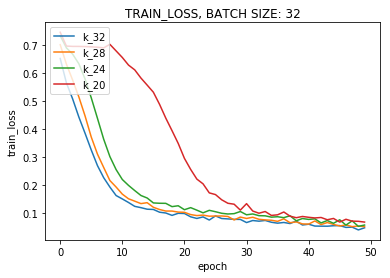

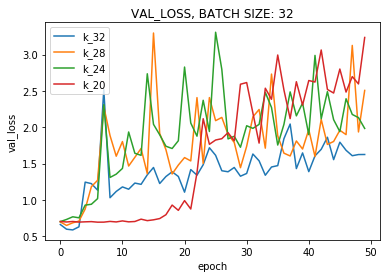

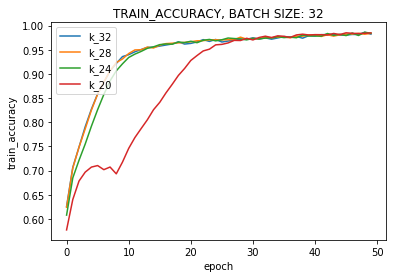

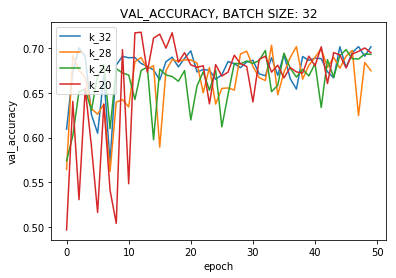

In [20]:
for metric in ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']:
    plot(metric, k_32_history, k_28_history, k_24_history, k_20_history)